In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

/kaggle/input/health-insurance-cross-sell-prediction/sample_submission.csv
/kaggle/input/health-insurance-cross-sell-prediction/train.csv
/kaggle/input/health-insurance-cross-sell-prediction/test.csv


## Load Data

In [2]:
train = pd.read_csv('/kaggle/input/health-insurance-cross-sell-prediction/train.csv')
test = pd.read_csv("/kaggle/input/health-insurance-cross-sell-prediction/test.csv")
submission = pd.read_csv("/kaggle/input/health-insurance-cross-sell-prediction/sample_submission.csv")

In [3]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [5]:
test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127037 entries, 0 to 127036
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    127037 non-null  int64  
 1   Gender                127037 non-null  object 
 2   Age                   127037 non-null  int64  
 3   Driving_License       127037 non-null  int64  
 4   Region_Code           127037 non-null  float64
 5   Previously_Insured    127037 non-null  int64  
 6   Vehicle_Age           127037 non-null  object 
 7   Vehicle_Damage        127037 non-null  object 
 8   Annual_Premium        127037 non-null  float64
 9   Policy_Sales_Channel  127037 non-null  float64
 10  Vintage               127037 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 10.7+ MB


In [7]:
submission.head()

,id,Response
0,381110,0
1,381111,0
2,381112,0
3,381113,0
4,381114,0


I don't need 'id' column. So, i dropped that.

In [8]:
train.drop('id', axis = 1, inplace = True)
test.drop('id', axis = 1, inplace = True)

I checked dtypes of each column.

1. object type
2. numeric type

In [9]:
obj_cols = train.columns[train.dtypes == object]
num_cols = train.columns[train.dtypes != object]

In [10]:
obj_cols

Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')

In [11]:
num_cols

Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

## EDA

I made custom function to make plot using object variable.

In [12]:
def obj_cnt_plot(column) :
    f, ax = plt.subplots(1, 2, figsize = (10, 6))
    plt.subplots_adjust(wspace = .4)
    f.suptitle(f'{column}')
    
    ax[0].set_title('Train')
    ax[1].set_title('Test')
    
    if column == 'Vehicle_Age' :
        order = train.Vehicle_Age.unique()
    else :
        order = None
        
    sns.countplot(train[column], ax = ax[0], edgecolor = (0,0,0), order = order)
    sns.countplot(test[column], ax = ax[1], edgecolor = (0,0,0), order = order)
    
    plt.show()

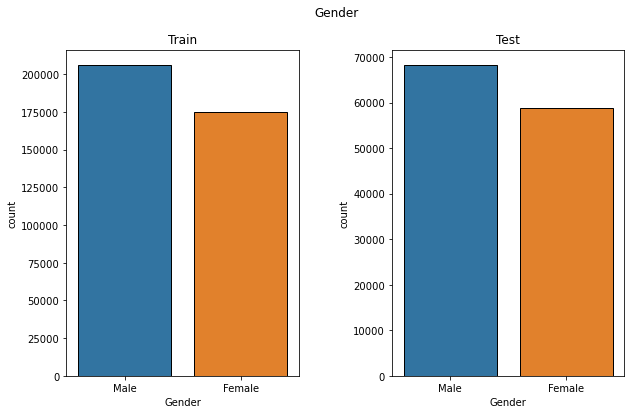

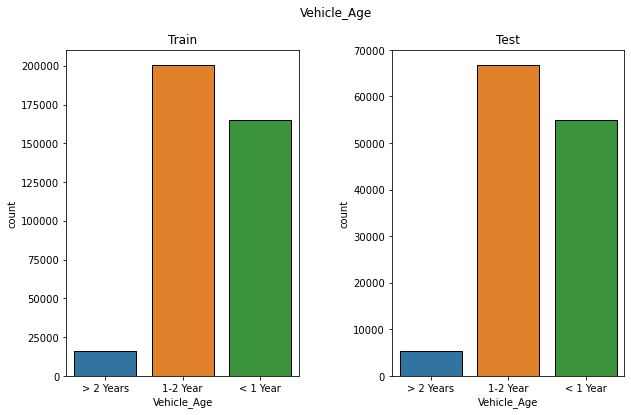

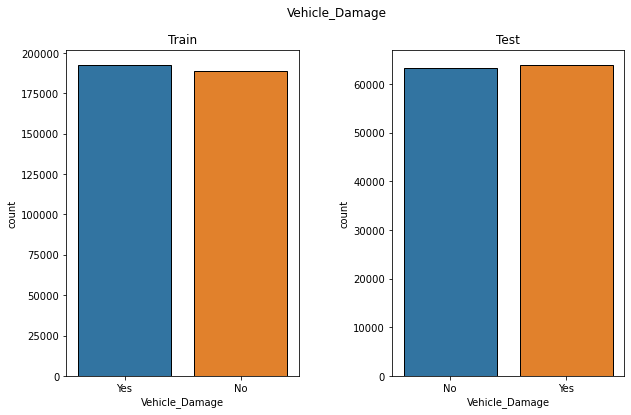

In [13]:
for c in obj_cols :
    obj_cnt_plot(c)

I checked that distribution of each data set(train, test) is very similar.

I did LabelEncoding to make object columns numeric type.

In [14]:
for c in obj_cols :
    le = LabelEncoder()
    train[c] = le.fit_transform(train[c])
    test[c] = le.transform(test[c])

I made custom function to make plot numeric columns.

In [15]:
def num_dis_plot(column) :
    plt.figure(figsize = (10, 6))
    plt.title(f"Distibution of {column}", size = 20)
    train[column].hist(color = 'b', label = 'Train')
    test[column].hist(color = 'r', label = 'Test')
    plt.legend()
    plt.show()
    print(f'Skewness of {column} in Train Data is {train[column].skew()}')
    print(f'Skewness of {column} in Test Data is {test[column].skew()}')

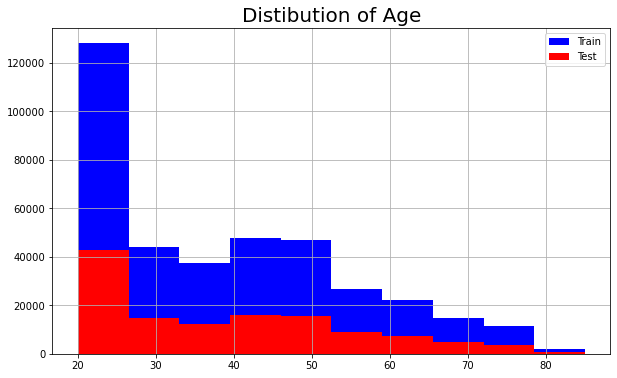

Skewness of Age in Train Data is 0.6725389977260843
Skewness of Age in Test Data is 0.6733565572159153


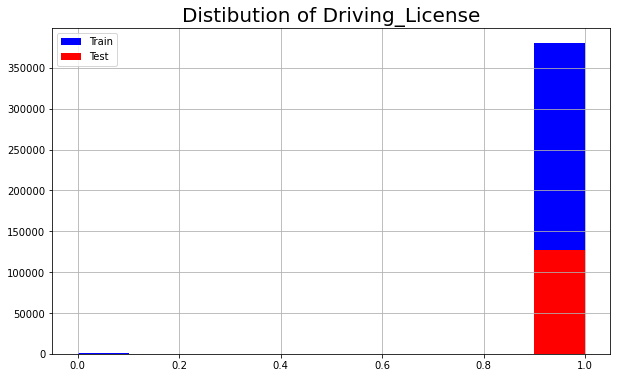

Skewness of Driving_License in Train Data is -21.595181529570038
Skewness of Driving_License in Test Data is -23.087562751886615


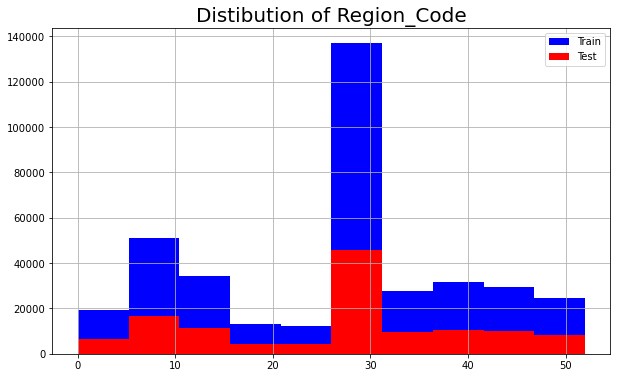

Skewness of Region_Code in Train Data is -0.11526641488610123
Skewness of Region_Code in Test Data is -0.12229143362812499


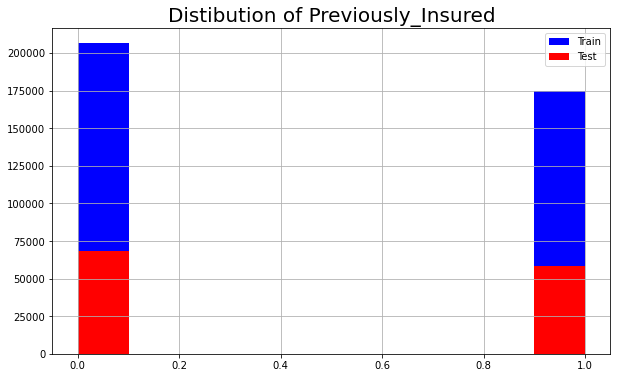

Skewness of Previously_Insured in Train Data is 0.1677471164589759
Skewness of Previously_Insured in Test Data is 0.160358043558042


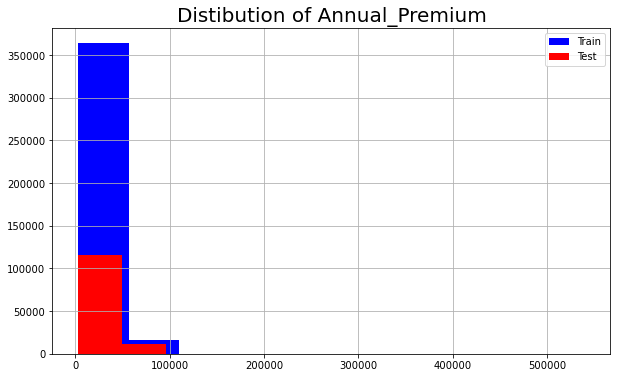

Skewness of Annual_Premium in Train Data is 1.7660872148961309
Skewness of Annual_Premium in Test Data is 1.0778667355761409


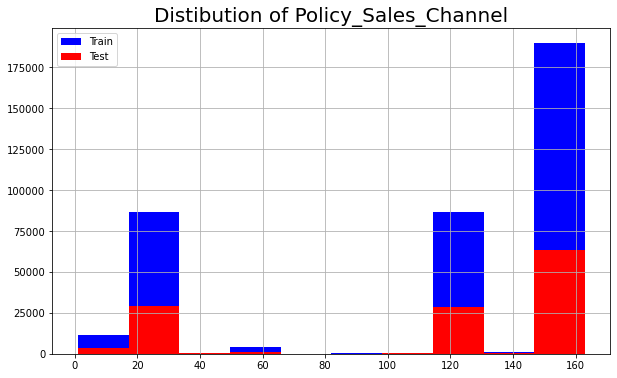

Skewness of Policy_Sales_Channel in Train Data is -0.9000081235103394
Skewness of Policy_Sales_Channel in Test Data is -0.8876418953028267


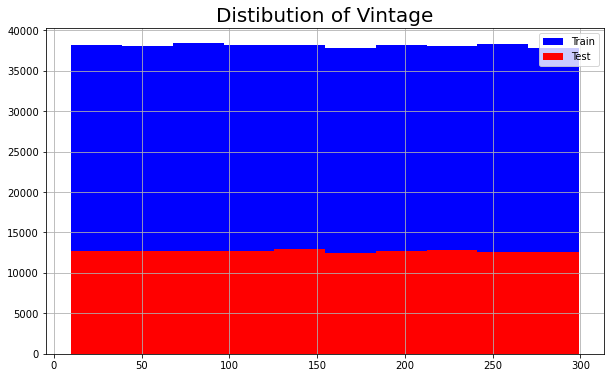

Skewness of Vintage in Train Data is 0.0030295168899980816
Skewness of Vintage in Test Data is 0.001467289451134076


In [16]:
for c in num_cols[:-1] :
    num_dis_plot(c)

I found that the skewness of each data set is almost same.

after that, I checked the variable to do log transfromation.

In [17]:
skew_tr = pd.DataFrame({'before' : train.skew(), 'after' : np.log1p(train).skew()})
skew_tr

,before,after
Gender,-0.163590,-0.163590
Age,0.672539,0.215195
Driving_License,-21.595182,-21.595182
Region_Code,-0.115266,-1.424748
Previously_Insured,0.167747,0.167747
Vehicle_Age,0.589682,0.276175
Vehicle_Damage,-0.019507,-0.019507
Annual_Premium,1.766087,-1.470591
Policy_Sales_Channel,-0.900008,-1.363040
Vintage,0.003030,-1.091957


In [18]:
skew_te = pd.DataFrame({'before' : test.skew(), 'after' : np.log1p(test).skew()})
skew_te

,before,after
Gender,-0.148953,-0.148953
Age,0.673357,0.216106
Driving_License,-23.087563,-23.087563
Region_Code,-0.122291,-1.444798
Previously_Insured,0.160358,0.160358
Vehicle_Age,0.586707,0.273509
Vehicle_Damage,-0.009966,-0.009966
Annual_Premium,1.077867,-1.471219
Policy_Sales_Channel,-0.887642,-1.352899
Vintage,0.001467,-1.098332


There are two variables to transform. 

1. Age
2. Vehicle_Age

In [19]:
train[['Age', 'Vehicle_Age']] = np.log1p(train[['Age', 'Vehicle_Age']])
test[['Age', 'Vehicle_Age']] = np.log1p(test[['Age', 'Vehicle_Age']])

After that, I made data for modeling.

In [20]:
X = train.drop('Response', axis = 1)
y = train.Response

## Modeling

I used 5 models

1. RandomForest
2. LightGBM
3. GradientBoosting
4. XGBoost
5. CatBoost

In [21]:
rf = RandomForestClassifier(random_state = 122)
lgbm = LGBMClassifier(random_state = 122)
gb = GradientBoostingClassifier(random_state = 122)
xgb = XGBClassifier(random_state = 122)
cb = CatBoostClassifier(random_state = 122, silent = True)

In [22]:
models = [rf, lgbm, gb, xgb, cb]

In [23]:
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 122)

In [24]:
model_acc = []
for model in models :
    acc_list = []
    for tr_idx, val_idx in skf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
        
        model.fit(tr_x, tr_y)
        
        pred = model.predict(val_x)
        
        acc = accuracy_score(val_y, pred)
        
        acc_list.append(acc)
    model_acc.append(np.mean(acc_list))

In [25]:
acc_df = pd.DataFrame({'model' : [x.__class__.__name__ for x in models], 'accuracy' : model_acc}).sort_values(by = 'accuracy', ascending = False)

In [26]:
acc_df

,model,accuracy
2,GradientBoostingClassifier,0.877434
1,LGBMClassifier,0.877103
4,CatBoostClassifier,0.876773
3,XGBClassifier,0.876639
0,RandomForestClassifier,0.866156


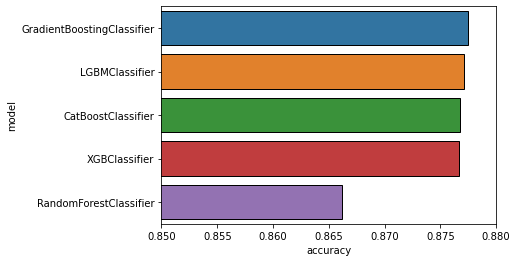

In [27]:
sns.barplot(x = acc_df.accuracy, y = acc_df.model, edgecolor = (0, 0, 0))
plt.xlim(.85, .88)
plt.show()

Finally, I used best 4 models and did ensemble method.

In [28]:
final_pred = []
for model in [xgb, gb, lgbm, cb] :
    sub_pred = np.zeros((test.shape[0], 1))
    
    for tr_idx, val_idx in skf.split(X, y) :    
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
        
        if model.__class__.__name__ == 'GradientBoostingClassifier' :
            model.fit(tr_x, tr_y)
        else :
            model.fit(tr_x, tr_y, eval_set = [(val_x, val_y)], verbose = 500, early_stopping_rounds = 300)
        
        pred = model.predict_proba(test)[:, 1] / 5
        sub_pred += pred.reshape(-1, 1)
        
    final_pred.append(sub_pred)

[0]	validation_0-error:0.12256
Will train until validation_0-error hasn't improved in 300 rounds.
[99]	validation_0-error:0.12300
[0]	validation_0-error:0.12256
Will train until validation_0-error hasn't improved in 300 rounds.
[99]	validation_0-error:0.12340
[0]	validation_0-error:0.12258
Will train until validation_0-error hasn't improved in 300 rounds.
[99]	validation_0-error:0.12326
[0]	validation_0-error:0.12256
Will train until validation_0-error hasn't improved in 300 rounds.
[99]	validation_0-error:0.12351
[0]	validation_0-error:0.12256
Will train until validation_0-error hasn't improved in 300 rounds.
[99]	validation_0-error:0.12364
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[56]	valid_0's binary_logloss: 0.265188
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[58]	valid_0's binary_logloss: 0.266346
Training until validation scores don't improve for

In [29]:
pred = np.ones((test.shape[0], 1))
for n in range(4) :
    pred *= final_pred[n].reshape(-1, 1)
pred **= .25

## Submission

In [30]:
submission.Response = [1 if x >= .5 else 0 for x in pred]

In [31]:
submission

,id,Response
0,381110,0
1,381111,0
2,381112,0
3,381113,0
4,381114,0
...,...,...
127032,508142,0
127033,508143,0
127034,508144,0
127035,508145,0


In [32]:
submission.to_csv("1st_submission.csv", index = False)

## Finished!